# Guide for twinpy/analysis/twinboundary_analyzer.py

In [1]:
%aiida
%reload_ext autoreload
%autoreload 2

In [6]:
import os
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import twinpy
from twinpy.interfaces.aiida.vasp import (AiidaVaspWorkChain,
                                          AiidaRelaxWorkChain)
from twinpy.interfaces.aiida.phonopy import AiidaPhonopyWorkChain
from twinpy.interfaces.aiida.shear import AiidaShearWorkChain
from twinpy.interfaces.aiida.twinboundary import AiidaTwinBoudnaryRelaxWorkChain
from twinpy.analysis.twinboundary_analyzer import TwinBoundaryAnalyzer
from twinpy.file_io import write_thermal_ellipsoid

jupyter_dir = os.path.join(os.path.dirname(twinpy.__file__), '..', 'jupyter')
sys.path.append(os.path.join(jupyter_dir, 'site-packages'))
from jupyter_help import show_info

# ======= Mg =================
# hexagonal_relax_pk = 344209  # twinpy
# hexagonal_phonon_pk = 490837  # twinpy
# twinboundary_pk = 484130   # twinpy
# additional_relax_pks = [579661, 580386, 580450, 580573]   # twinpy
# twinboundary_phonon_pk = 581464   # twinpy
# twinboundary_shear_relax_pks = [326425, 297874, 297890, 297907, 297924]
# twinboundary_shear_phonon_pks = [326490, 299318, 300184, 300580, 300760]
# shear_strain_ratios = [0.00, 0.02, 0.04, 0.06, 0.08]
# ======= Mg =================


# ======= Ti =================
hexagonal_relax_pk = 366263  # twinpy
# hexagonal_phonon_pk = 493118  # Ti_pv rlx:366263 sup:222 ms:774
# hexagonal_phonon_pk = 493091  # Ti_pv rlx:366263 sup:333 ms:552
hexagonal_phonon_pk = 493063  # Ti_pv rlx:366263 sup:443 ms:332
twinboundary_pk = 545957   # twinpy
additional_relax_pks = [579637, 580347, 580599]   # twinpy
twinboundary_phonon_pk = None   # twinpy
# ======= Ti =================



# class TwinBoundaryAnalyzer

In [7]:
aiida_twinboundary_relax = AiidaTwinBoudnaryRelaxWorkChain(load_node(twinboundary_pk))
twinboundary_analyzer = aiida_twinboundary_relax.get_twinboundary_analyzer(
                            twinboundary_phonon_pk=twinboundary_phonon_pk,
                            hexagonal_relax_pk=hexagonal_relax_pk,
                            hexagonal_phonon_pk=hexagonal_phonon_pk,
                            additional_relax_pks=additional_relax_pks)
show_info(twinboundary_analyzer, is_class=True)

====== START class information ======

# ---------
# docstring
# ---------

    Analyze shear result.
    

# ----
# init
# ----

        Args:
            twinboundary_structure:TwinBoundaryStructure object.
            hexagonal_phonon_analyzer: PhononAnalyzer class object.
            twinboundary_phonon_analyzer: PhononAnalyzer class object.
        

# ---------------
# attribute names
# ---------------
['_twinboundary_structure',
 '_relax_analyzer',
 '_phonon_analyzer',
 '_hexagonal_relax_analyzer',
 '_hexagonal_phonon_analyzer',
 '_standardize']

# ------
# values
# ------
{'_hexagonal_phonon_analyzer': <twinpy.analysis.phonon_analyzer.PhononAnalyzer object at 0x7fea08343c10>,
 '_hexagonal_relax_analyzer': <twinpy.analysis.relax_analyzer.RelaxAnalyzer object at 0x7fea082a2810>,
 '_phonon_analyzer': None,
 '_relax_analyzer': <twinpy.analysis.relax_analyzer.RelaxAnalyzer object at 0x7fea0829e190>,
 '_standardize': <twinpy.structure.standardize.StandardizeCell object at 0x7fea0834a

## def get_formation_energy

In [8]:
show_info(twinboundary_analyzer.get_formation_energy)
print(twinboundary_analyzer.get_formation_energy())

====== START method information ======

# ---------
# docstring
# ---------

        Get formation energy. Unit [mJ/m^(-2)]

        Args:
            use_relax_lattice (bool): If True, relax lattice is used.
        

======= END method information =======


328.8520763172535


## def get_shear_cell

In [9]:
show_info(twinboundary_analyzer.get_shear_cell)
original_cells = []
for ratio in shear_strain_ratios:
    original_cell = twinboundary_analyzer.get_shear_cell(
        shear_strain_ratio=ratio,
        is_standardize=False)
    original_cells.append(original_cell)
original_cells[1]

====== START method information ======

# ---------
# docstring
# ---------

        Get shear introduced twinboundary cell.

        Args:
            shear_strain_ratio (float): shear strain ratio
            is_standardize (bool): if True, get standardized cell

        Returns:
            tuple: shear introduced cell

        Notes:
            original relax cell is use to create shear cell which is a little
            bit different shear value with respect to bulk shear value
            but I expect this is neglectable.
        

======= END method information =======




NameError: name 'shear_strain_ratios' is not defined

## def get_twinboudnary_shear_analyzer

In [10]:
show_info(twinboundary_analyzer.get_twinboundary_shear_analyzer)
phonon_analyzers = []
for i in range(len(original_cells)):
    aiida_relax = AiidaRelaxWorkChain(load_node(twinboundary_shear_relax_pks[i]))
    relax_analyzer = aiida_relax.get_relax_analyzer(original_cell=original_cells[i])
    aiida_phonon = AiidaPhonopyWorkChain(load_node(twinboundary_shear_phonon_pks[i]))
    phonon_analyzer = aiida_phonon.get_phonon_analyzer(relax_analyzer=relax_analyzer)
    phonon_analyzers.append(phonon_analyzer)

twinboundary_shear_analyzer = \
    twinboundary_analyzer.get_twinboundary_shear_analyzer(
        shear_phonon_analyzers=phonon_analyzers,
        shear_strain_ratios=shear_strain_ratios)
print(twinboundary_shear_analyzer)

====== START method information ======

# ---------
# docstring
# ---------

        Get TwinBoundaryShearAnalyzer class object.

        Args:
            shear_phonon_analyzers (list): List of additional shear
                                           phonon analyzers.
            shear_strain_ratios (list): Shear shear_strain_ratios.
        

======= END method information =======




NameError: name 'shear_strain_ratios' is not defined

## def get_atomic_environment

In [11]:
show_info(twinboundary_analyzer.get_atomic_environment)
atomic_envs = twinboundary_analyzer.get_atomic_environment()
pprint(atomic_envs)

====== START method information ======

# ---------
# docstring
# ---------

        Get plane coords from lower plane to upper plane.
        Return list of z coordinates of original cell frame.
        Plane coordinates (z coordinates) are fractional.

        Returns:
            tuple: First and second element are for initial and final cell
                   respectively. Each contains (planes, distances, angles)
        

======= END method information =======


[([0.0,
   1.69529413,
   3.4105878,
   5.12588203,
   6.84117608,
   8.55646937,
   10.2717636,
   11.98705765,
   13.70235131,
   15.41764555,
   17.13293959,
   18.82823334,
   20.5235271,
   22.23882114,
   23.95411538,
   25.66940904,
   27.38470309,
   29.09999732,
   30.81529061,
   32.53058466,
   34.24587889,
   35.96117256],
  [1.69529413,
   1.71529367,
   1.7152942299999996,
   1.7152940500000007,
   1.71529329,
   1.7152942299999996,
   1.7152940500000007,
   1.7152936599999986,
   1.7152942400000004,
   1.71

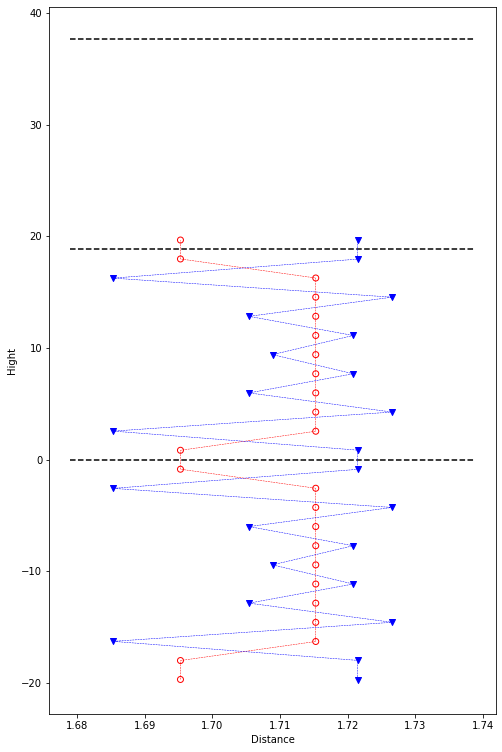

In [12]:
fig = twinboundary_analyzer.plot_plane_diff()

## def plot_angle_diff

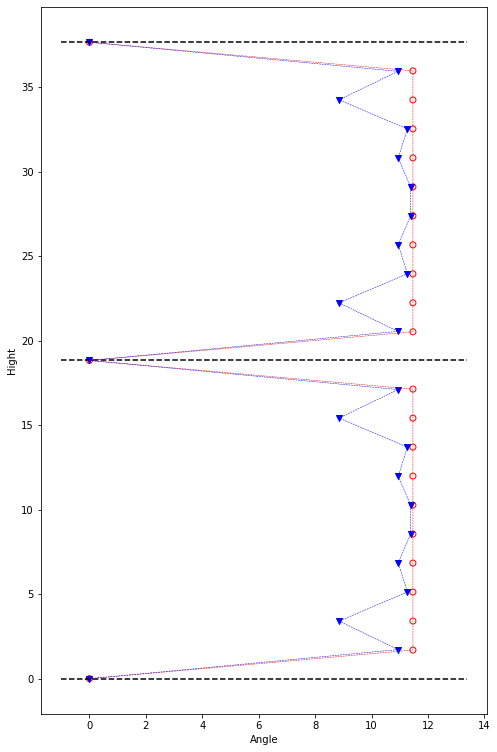

In [13]:
fig = twinboundary_analyzer.plot_angle_diff()

## def plot_atom_diff

The length of a axis is changed, so x in 'shuffle=False' does not zero


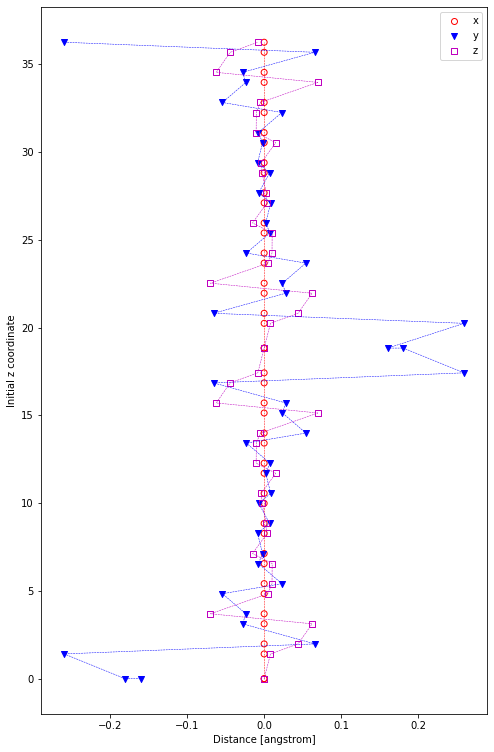

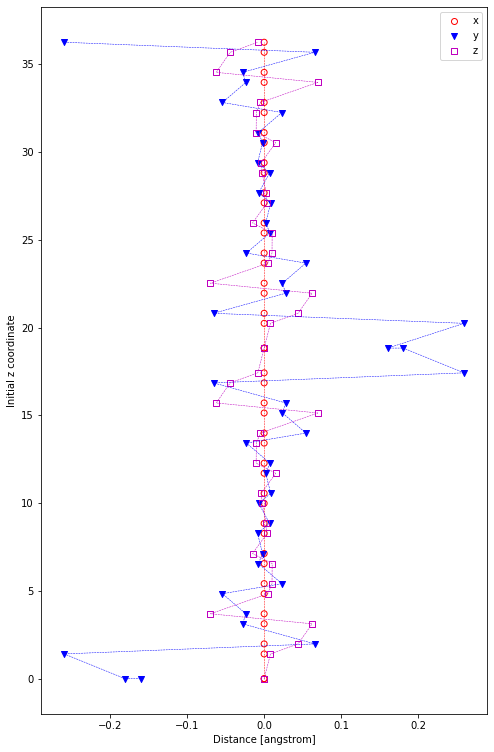

In [14]:
twinboundary_analyzer.plot_atom_diff(shuffle=False)
twinboundary_analyzer.plot_atom_diff(shuffle=True)
print("The length of a axis is changed, so x in 'shuffle=False' does not zero")